In [1]:
from config import *
from utils import *

import os
import sys
import copy
import numpy as np
import collections
import multiprocessing
import pickle

import numpy as np
import scipy

# Suppress pandas future warning, which messes tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(INDELPHI_DIR)
import inDelphi

# inDelphi Evaluation using dat-A

In [2]:
unnorm_gt_indel_dist_map = load_var(UNNORM_GT_INDEL_DIST_MAP)
gt_indel_dist_map = load_var(GT_INDEL_DIST_MAP)

## inDelphi Repair Genotypes and Frequencies Predictions

In [3]:
inDelphi.init_model(celltype = INDELPHI_CELL_TYPE)

Initializing model aax/aag, mESC...
Done


In [4]:
def preddf_to_distribution(pred_df, seq, cutsite, g_orientation):
    distribution = generate_empty_distribution()
    
    # Insertion
    insertion_pred_df = pred_df.loc[pred_df['Category'] == 'ins']
    for index, row in insertion_pred_df.iterrows():
        ib = row['Inserted Bases'] if g_orientation == '+' else reverse_complement(row['Inserted Bases'])
        distribution[1][ib] = row['Predicted frequency']
    
    # Deletions (including microhomology-less deletions)
    deletion_pred_df = pred_df.loc[(pred_df['Category'] == 'del')]
    for index, row in deletion_pred_df.iterrows():
        deletion_size = row['Length']
        genotype = row['Genotype'] if g_orientation == '+' else reverse_complement(row['Genotype'])
        frequency = row['Predicted frequency']
        
        # Ignore big deletions. inDelphi doesn't predict more than 60bp deletions
        if deletion_size > MAX_INDEL_LEN:
            continue
    
        # To be consistent and make for meaningful comparisons,
        # don't use the genotype pos from inDelphi--it's unclear what their tie-breaking criteria is
        # so we'll use the same genotype pos determining logic used to generate the experimental distribution
        for genotype_pos, simulated_product in generate_product(seq, cutsite, deletion_size):
            if simulated_product == genotype:
                distribution[-deletion_size][genotype_pos] = frequency
                break
                
    return distribution

def predict_indel_distribution(pair):
    g_seq, t_seq, g_orientation = pair
    cutsite = get_cutsite(g_seq, t_seq, g_orientation)
    
    inDelphi_seq = t_seq
    inDelphi_cutsite = cutsite
    # If guide orientation is '-':
    # Reverse complement the seq
    # Adjust cutsite location to be relative to revcomplement
    # Predict with indelphi
    # in preddf_to_distribution, revcomp the products
    if g_orientation == '-':
        inDelphi_seq = reverse_complement(t_seq)
        inDelphi_cutsite = len(t_seq) - cutsite
    pred_df, stats = inDelphi.predict(inDelphi_seq, inDelphi_cutsite)
    
    pred_df = inDelphi.add_mhless_genotypes(pred_df, stats)
    
    pred_df = inDelphi.add_genotype_column(pred_df, stats)
    return preddf_to_distribution(pred_df, t_seq, cutsite, g_orientation)

def predict_indel_dist_map(pairs):
    indel_dist_map = {}
    for pair in tqdm(pairs):
        distribution = predict_indel_distribution(pair)
        normalize_distribution(distribution)
        indel_dist_map[pair] = distribution
    return indel_dist_map

In [5]:
if not pickle_exists(PREDICTED_GT_INDEL_DIST_MAP):
    predicted_gt_indel_dist_map = predict_indel_dist_map(lib_pairs)
    save_var(predicted_gt_indel_dist_map, PREDICTED_GT_INDEL_DIST_MAP)
else:
    predicted_gt_indel_dist_map = load_var(PREDICTED_GT_INDEL_DIST_MAP)

## inDelphi Prediction Accuracy Evaluation

In [6]:
def pearsonr(p, q):
    return scipy.stats.pearsonr(p, q)[0]


def distribution_distance(p, q):
    return pearsonr(p, q)

In [7]:
def plot_r_vs_support():
    distances = []
    num_unique_products = []
    num_observed_products = []
    for gt in tqdm(gt_indel_dist_map):
        q = distribution_to_list(gt_indel_dist_map[gt])[0]
        p = distribution_to_list(predicted_gt_indel_dist_map[gt])[0]
        num_unique = sum(f > 0 for f in q)
        num_observed = sum(distribution_to_list(unnorm_gt_indel_dist_map[gt])[0])
        if num_observed > 0 and num_unique > 0:
            distance = distribution_distance(p, q)
            distances.append(distance)
            num_unique_products.append(num_unique)
            num_observed_products.append(num_observed)

    fig, ax = plt.subplots(figsize=(10,5))
    sns.scatterplot(np.log10(num_observed_products), distances, size=num_unique_products, ax = ax)
    ax.set(xlabel='$log_{10}$(Num Products Observed)', ylabel="Pearson's $r$", title="Pearson's $r$ vs Num Observations")
    plt.show()
    print(len(distances))
    print("Mean:", np.mean(distances))
    print("Median:", np.median(distances))

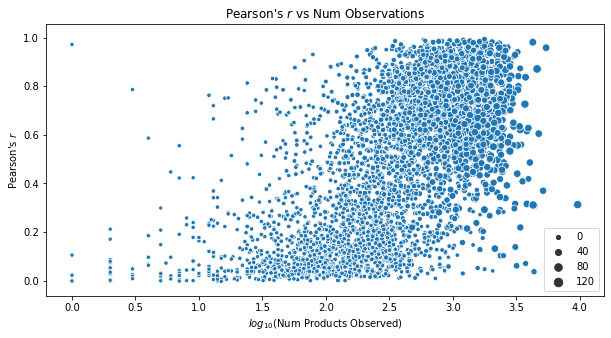

3963
Mean: 0.48449855241587425
Median: 0.5245246158732907


In [8]:
plot_r_vs_support()

From the above plot, we see that we can consider gRNA/Target pairs with fewer than 100 repair observations, and fewer than 20 unique repair outcomes, as not enough data support. After eliminating them, we're left with 1.695 gRNAs that target 1,549 Targets.

In [9]:
MIN_NUM_OBS = 100
MIN_UNIQUE = 20

In [10]:
def datA_table():
    gid = []
    category = []
    genotype_pos = []
    inserted_bases = []
    length = []
    empirical_frequency = []
    inDelphi_frequency = []
    
    for gt in tqdm(gt_indel_dist_map):
        q, q_labels = distribution_to_list(gt_indel_dist_map[gt])
        p, p_labels = distribution_to_list(predicted_gt_indel_dist_map[gt])
        num_unique = sum(f > 0 for f in q)
        num_observed = sum(distribution_to_list(unnorm_gt_indel_dist_map[gt])[0])
        if num_observed > MIN_NUM_OBS and num_unique > MIN_UNIQUE:
            for i in range(len(q_labels)):
                label = q_labels[i]
                gid.append(exp_grna_gid_map[gt[0]][0])
                
                if label[0] == '1':
                    category.append('ins')
                    genotype_pos.append(None)
                    inserted_bases.append(label[1])
                    length.append(1)
                else:
                    del_len, gen_pos = label.split(',')
                    del_len = -int(del_len)
                    gen_pos = int(gen_pos)
                    category.append('del')
                    genotype_pos.append(gen_pos)
                    inserted_bases.append(None)
                    length.append(del_len)
                
                empirical_frequency.append(q[i])
                inDelphi_frequency.append(p[i])
    df = pd.DataFrame({
        'gRNA ID': gid,
        'Category': category,
        'Genotype position': genotype_pos,
        'Inserted Bases': inserted_bases,
        'Length': length,
        'Empirical frequency': empirical_frequency,
        'Predicted frequency': inDelphi_frequency
    })
    return df
            

def plot_distance_distributions():
    distances = []
    num_unique_products = []
    num_observed_products = []
    for gt in tqdm(gt_indel_dist_map):
        q = distribution_to_list(gt_indel_dist_map[gt])[0]
        p = distribution_to_list(predicted_gt_indel_dist_map[gt])[0]
        num_unique = sum(f > 0 for f in q)
        num_observed = sum(distribution_to_list(unnorm_gt_indel_dist_map[gt])[0])
        if num_observed > MIN_NUM_OBS and num_unique > MIN_UNIQUE:
            distance = distribution_distance(p, q)
            distances.append(distance)
            num_unique_products.append(num_unique)
            num_observed_products.append(num_observed)

    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize=(5,5))
    sns.distplot(distances, kde=False, ax = ax)
    ax.set(xlabel="Pearson's $r$", ylabel='Number of gRNA-Target Pairs (' + str(len(distances)) + ' Total)', title="Pearson's $r$ between Observed and\ninDelphi Predicted Indel Distributions")
    median = np.median(distances)
    plt.axvline(median, color='gray', linestyle='dotted')
    plt.text(median - 0.4, 175, 'Median $r = ' + "{:.2f}".format(median) +'$')
    plt.savefig(os.path.join(IMAGES_DIR, 'indelphi_r.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print('gRNAs:', len(distances))
    print("Median:", np.median(distances))
    print("Mean unique prods per grna:", np.mean(num_unique_products))
    print("Mean reads per grna:", np.mean(num_observed_products))
    print("Total reads:", np.sum(num_observed_products))

## S2 Table

In [11]:
datA_df = datA_table()

In [12]:
datA_df.head()

,gRNA ID,Category,Genotype position,Inserted Bases,Length,Empirical frequency,Predicted frequency
0,8495,ins,NaN,A,1,0.018119,0.009339
1,8495,ins,NaN,G,1,0.000000,0.001777
2,8495,ins,NaN,T,1,0.000211,0.004559
3,8495,ins,NaN,C,1,0.049616,0.070707
4,8495,del,0.0,None,1,0.167597,0.032842


In [13]:
datA_df['gRNA ID'].nunique()

1695

In [14]:
datA_df.to_csv(os.path.join(TABLES_DIR, 'datA_table.csv.gz'), index=False, compression='gzip')

## Figure 2C

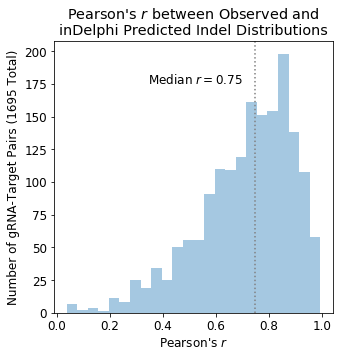

gRNAs: 1695
Median: 0.745429259029706
Mean unique prods per grna: 44.60530973451328
Mean reads per grna: 1179.3064896755163
Total reads: 1998924.5


In [15]:
plot_distance_distributions()

In [16]:
def insertion_expected_vs_empirical():
    def get_expected_insertion(gt):
        g, t, _ = gt
        guide_id, g_orientation = exp_grna_gid_map[g]
        guide_row = exp_design.loc[guide_id]
        guide_orientation = guide_row['gRNA orientation']
        guide_seq = guide_row['gRNA']
        return guide_seq[3] if guide_orientation == '-' else guide_seq[-4]

    expected_bases = []
    actual_bases = []
    actual_freq = []
    order_exp = []
    order_act = []
    t_set = set()
    for gt in tqdm(unnorm_gt_indel_dist_map):
        q = distribution_to_list(unnorm_gt_indel_dist_map[gt])[0]
        
        num_unique = sum(f > 0 for f in q)
        num_observed = sum(q)
        if not (num_observed > MIN_NUM_OBS and num_unique > MIN_UNIQUE):
            continue
            
        t_set.add(gt[1])
        exp_b = get_expected_insertion(gt)
        order_exp_b = 'AGTC'.index(exp_b)
        actual_b_dist = np.array(q[0:4])/sum(q[0:4]) # AGTC normalized
        for i, b in enumerate('AGTC'):
            expected_bases.append(exp_b)
            actual_bases.append(b)
            order_exp.append(order_exp_b)
            order_act.append(i)
            actual_freq.append(actual_b_dist[i])
            
    print('Target sequences:', len(t_set))
    df = pd.DataFrame({
        'Expected': expected_bases,
        'Actual': actual_bases,
        'orderexp': order_exp,
        'orderact': order_act,
        'Frequency': actual_freq
    })
    df = df.sort_values(["orderexp", "orderact"], ascending=True)
    return df

## Figure 2B

In [17]:
insertion_exp_vs_obs_df = insertion_expected_vs_empirical()

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide



Target sequences: 1549


In [18]:
def plot_insertion_dist(df):
    fig, ax = plt.subplots(figsize=(5,5))
    with sns.color_palette("muted"):
        flierprops = dict(markerfacecolor='0.75', markeredgecolor='0.75', markersize=2,
              linestyle='none')
        sns.boxplot(x="Expected", y="Frequency", flierprops=flierprops,
                    hue="Actual", data=df, ax=ax)
        ax.set(xlabel="Nucleotide at Position -4", ylabel='Frequency of inserted base among 1-bp insertions', title="")
        plt.legend(title='Inserted Base', bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=4, borderaxespad=0.)
        plt.savefig(os.path.join(IMAGES_DIR, 'indelphi_insert.png'), dpi=300, bbox_inches='tight')
        plt.show()

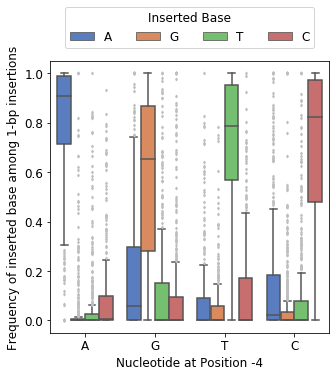

In [19]:
plot_insertion_dist(insertion_exp_vs_obs_df)

In [20]:
r_gt = []
for gt in tqdm(gt_indel_dist_map):
    q = distribution_to_list(gt_indel_dist_map[gt])[0]
    p = distribution_to_list(predicted_gt_indel_dist_map[gt])[0]
    num_unique = sum(f > 0 for f in q)
    num_observed = sum(distribution_to_list(unnorm_gt_indel_dist_map[gt])[0])
    if num_observed > MIN_NUM_OBS and num_unique > MIN_UNIQUE:
        distance = distribution_distance(p, q)
        r_gt.append((distance, gt))
r_gt = sorted(r_gt, reverse=True)

In [21]:
def pretty_plot_distributions(gt):
    fig, ax = plt.subplots(figsize=(5,4))
    
    q, q_labels = distribution_to_list(gt_indel_dist_map[gt])
    p, p_labels = distribution_to_list(predicted_gt_indel_dist_map[gt])
    indel_labels = []
    identity = [] # Predicted or Observed
    frequencies = []

    for i in range(len(q)):
        if len(frequencies) == 14:
            break
            
        if p[i] > 0 and q[i] > 0:
            cutsite = get_cutsite(*gt)
            target = gt[1]
            if q_labels[i][0] == '1':
                indel_str = target[0:cutsite] + q_labels[i][1] + target[cutsite:]
            else:
                l = q_labels[i].split(',')
                deletion_size, genotype_pos = -int(l[0]), int(l[1])
                indel_str = target[0:(cutsite + genotype_pos - deletion_size)] + ('-'*(-genotype_pos + deletion_size)) + '|' + ('-'*genotype_pos) + target[(cutsite + genotype_pos):]
            
            flank_size = 22
            indel_str = '...'+indel_str[cutsite-flank_size:cutsite+flank_size+1]+'...'
            
            identity.append('Observed')
            indel_labels.append(indel_str)
            frequencies.append(q[i]*100)
            
            identity.append('Predicted')
            indel_labels.append(indel_str)
            frequencies.append(p[i]*100)
            print(indel_str, p[i])
            
    indel_str = target[0:cutsite] + '|' + target[cutsite:]
    indel_str = '...'+indel_str[cutsite-flank_size:cutsite+flank_size+1]+'...'
    identity.append('Observed')
    indel_labels.append('')
    frequencies.append(0)
    identity.append('Predicted')
    indel_labels.append('')
    frequencies.append(0)
            
    df = pd.DataFrame({
        'Indel': indel_labels,
        'Group': identity,
        'Frequency (%)': frequencies
    })
    
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = 12
    plt.rcParams['text.usetex'] = False
    with sns.color_palette("muted"):
        g = sns.barplot(x="Frequency (%)", y="Indel", hue="Group", data=df, ax=ax)
        g.axes.set_xlim(0,100)
        g.set_ylabel('')
        sns.despine(top=False, right=True, left=False, bottom=True)
        space=1.0
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()/2
            value = '{:.1f}'.format(p.get_width()) + '%'
            if p.get_width() > 0:
                ax.text(_x, _y, value, ha="left", va='center')
        g.xaxis.set_ticks_position("top")
        g.xaxis.set_label_position('top')
        plt.legend(loc='lower right')

        g.axes.annotate(s=indel_str, xy=(0,0), xytext=(-135,-0.9))
        g.axes.annotate(s='...', xy=(0,0), xytext=(-135/2 - 5.1,0.9*8), rotation=90)
        g.axes.annotate(s='...', xy=(0,0), xytext=(20,0.9*8), rotation=90)
#         plt.savefig('images/indelphi_dist_ex.png', dpi=300, bbox_inches='tight')
        plt.show()

...CTCAACCTGATTTTCTCCTGCAAGCACTATGAGCAGACTGCTCCC... 0.03895537949493695
...CTCAACCTGATTTTCTCCTGCAGGCACTATGAGCAGACTGCTCCC... 0.042984042913970164
...CTCAACCTGATTTTCTCCTGC-|GCACTATGAGCAGACTGCTCCC... 0.020406229297064624
...CTCAACCTGATTTTCTCCTGCA|-CACTATGAGCAGACTGCTCCC... 0.020406229297064624
...CTCAACCTGATTTTCTCCTG--|GCACTATGAGCAGACTGCTCCC... 0.010528278988922722
...CTCAACCTGATTTTCTCCT---|GCACTATGAGCAGACTGCTCCC... 0.5178616323950719
...CTCAACCTGATTTTCTCC----|GCACTATGAGCAGACTGCTCCC... 0.005336251049209055


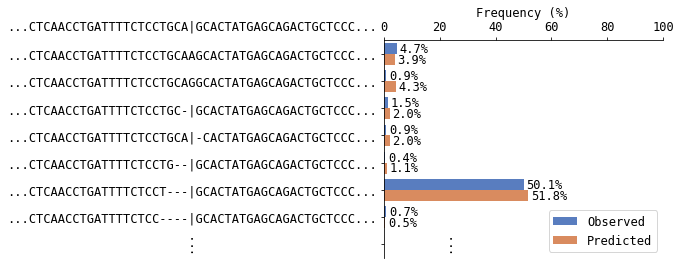

In [23]:
## Figure 2D
pretty_plot_distributions(r_gt[7][-1])